# **AI for Stock Decisions**

 In the financial industry, stock price prediction is a crucial problem that has a strong impact on risk management, investment decisions and market stability. Classical stock analysis techniques usually rely on expert intuition, historical averages, or manual chart examining, all of which can be difficult, inaccurate, and unreliable at identifying complex market trends. Machine learning provides a more powerful approach by leveraging historical trading data to identify hidden trends and relationships that may not be visible through conventional techniques. By applying advanced models, it becomes possible to predict closing prices for the next 2–3 days with improved accuracy. Furthermore, combining these predictions with classification techniques, such as Logistic Regression, enables the system to recommend actionable decisions—whether to buy a stock or not. The inputs for this task include daily trading attributes such as date, change, opening price, closing price, highest and lowest values, and trading volume, while the outputs are the predicted future closing price and the buy/not buy recommendation,

## **Section 1 — Data Cleaning**

In this section, we prepare the Saudi equities dataset for analysis and modeling.  
Steps include:
- Load the full historical dataset using Arabic-safe encodings.  
- Validate that key columns (`القطاع`, `رمز الشركة`, `اسم الشركة`, `التاريخ`, `إقفال`) are correctly aligned.  
- Perform full cleaning: remove invalid entries, parse Arabic dates, convert all numeric fields, and drop duplicates or missing critical rows.  
- Keep only the **essential columns** needed for modeling:  
  **[القطاع, رمز الشركة, اسم الشركة, التاريخ, إقفال]**.  
- Save the cleaned dataset.  
- Build a **4-year subset** (latest four complete calendar years).  
- From that subset, select **up to 10 sectors**, each with **10 companies**, keeping **all dates** for those firms.  
- Save both the cleaned full dataset and the 10×10 subset for the modeling stage.


### Step 1: Imports & Paths

In this step, we import all the required Python libraries and set up the project file paths.  
- **pandas** and **numpy** are used for handling and analyzing the dataset.  
- **pathlib.Path** helps manage file and directory paths in a clean, platform-independent way.  
- We also define the output filenames for the cleaned dataset and the filtered 4-year, 10-sector subset.

This setup ensures that all directories and paths are properly initialized before loading and cleaning the data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Imports & Paths
import pandas as pd
import numpy as np
from pathlib import Path

# Path to the raw CSV
SOURCE_PATH = Path("/content/drive/MyDrive/Equites_Historical_Adjusted_Prices_Report.csv")

# Output files
OUT_DIR = Path(".")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_CSV = OUT_DIR / "cleaned_equities_all_years.csv"
SELECTED_CSV = OUT_DIR / "equities_4yrs_10sectors_10companies.csv"

print("Using:", SOURCE_PATH)
print("Will save ->", CLEAN_CSV.name, "and", SELECTED_CSV.name)


Using: /content/drive/MyDrive/Equites_Historical_Adjusted_Prices_Report.csv
Will save -> cleaned_equities_all_years.csv and equities_4yrs_10sectors_10companies.csv


### Step 2: Load Dataset and Validate Arabic Schema

In this step, we load the equities dataset using multiple Arabic-friendly encodings to ensure correct character reading.  
We also verify that the key columns are properly aligned and interpreted as intended:  

- **القطاع** → sector or industry (e.g., البنوك)  
- **رمز الشركة** → company code (e.g., 1010)  
- **اسم الشركة** → company name (e.g., بنك الرياض)  
- **التاريخ** → date column  
- **إقفال** → closing price  

If a column shift occurred (for example, when the sector was stored as an index), the code automatically realigns the columns.  
Finally, we confirm the structure by printing a few sample values from the main columns.


In [ ]:
# Load CSV and ensure correct Arabic schema
import pandas as pd
import numpy as np

ENCODINGS = ["utf-8-sig", "utf-8", "cp1256", "windows-1256"]
for enc in ENCODINGS:
    try:
        df_try = pd.read_csv(SOURCE_PATH, encoding=enc)
        break
    except Exception:
        continue

expected = [
    'القطاع','رمز الشركة','اسم الشركة','التاريخ',
    'إفتتاح','الأعلى','الأدنى','إقفال',
    'التغيير','% التغيير','الكمية المتداولة',
    'اجمالي القيمة المتداولة (ر.س)','عدد الصفقات'
]

def looks_correct(d):
    # sector should look textual (not mostly digits)
    s = d['القطاع'].astype(str)
    pct_digits = s.str.fullmatch(r'\d+(\.\d+)?').mean()
    sector_ok = pct_digits < 0.2

    # code should be mostly numeric (like 1010)
    c = d['رمز الشركة'].astype(str)
    code_ok = c.str.fullmatch(r'\d+').mean() > 0.7

    # name should look like Arabic words (not mostly numbers/dates)
    n = d['اسم الشركة'].astype(str)
    name_ok = (~n.str.fullmatch(r'\d+|[0-9\-/:A-Za-z]+')).mean() > 0.6

    return sector_ok and code_ok and name_ok

df = None

# Case 1: columns already match expected order
if set(expected).issubset(set(df_try.columns)):
    df = df_try[expected].copy()
    if not looks_correct(df):
        df = None  # fall through to the index_col fix

# Case 2: try the common “sector-as-index” mis-save and realign names
if df is None:
    df_idx = pd.read_csv(SOURCE_PATH, encoding=enc, index_col=0).reset_index()
    fixed_names = [
        'القطاع', 'رمز الشركة', 'اسم الشركة', 'التاريخ',
        'إفتتاح','الأعلى','الأدنى','إقفال',
        'التغيير','% التغيير','الكمية المتداولة',
        'اجمالي القيمة المتداولة (ر.س)','عدد الصفقات'
    ]
    df_idx = df_idx.iloc[:, :len(fixed_names)]
    df_idx.columns = fixed_names
    df = df_idx.copy()

# Final assert the meaning:
assert looks_correct(df), "Column meaning still looks off — inspect the raw file."

print("Aligned columns OK:", list(df.columns))
print("Samples -> sector/name/code:\n",
      "القطاع:", df['القطاع'].head(3).tolist(),
      "\nاسم الشركة:", df['اسم الشركة'].head(3).tolist(),
      "\nرمز الشركة:", df['رمز الشركة'].head(3).tolist(),
      "\nإقفال:", df['إقفال'].head(3).tolist())

Aligned columns OK: ['القطاع', 'رمز الشركة', 'اسم الشركة', 'التاريخ', 'إفتتاح', 'الأعلى', 'الأدنى', 'إقفال', 'التغيير', '% التغيير', 'الكمية المتداولة', 'اجمالي القيمة المتداولة (ر.س)', 'عدد الصفقات']
Samples -> sector/name/code:
 القطاع: ['البنوك', 'البنوك', 'البنوك'] 
اسم الشركة: ['بنك الرياض', 'بنك الرياض', 'بنك الرياض'] 
رمز الشركة: [1010, 1010, 1010] 
إقفال: [28.1, 29.05, 28.0]


In [ ]:
missing_summary = df.isna().sum().to_frame(name="missing_count")
missing_summary["missing_pct"] = (missing_summary["missing_count"] / len(df)) * 100
missing_summary = missing_summary.sort_values("missing_pct", ascending=False)

print("Missing values per column:")
print(missing_summary)

Missing values per column:
                               missing_count  missing_pct
القطاع                                     0          0.0
رمز الشركة                                 0          0.0
اسم الشركة                                 0          0.0
التاريخ                                    0          0.0
إفتتاح                                     0          0.0
الأعلى                                     0          0.0
الأدنى                                     0          0.0
إقفال                                      0          0.0
التغيير                                    0          0.0
% التغيير                                  0          0.0
الكمية المتداولة                           0          0.0
اجمالي القيمة المتداولة (ر.س)              0          0.0
عدد الصفقات                                0          0.0


### Step 3: Core Data Cleaning

In this step, we apply consistent and safe cleaning operations to prepare the dataset for further analysis.

Key actions include:
- Remove any records for the company **«البنك الأول»** (if it exists).  
- Convert the **التاريخ** column to a proper `datetime` format using day-first parsing.  
- Convert Arabic-encoded numeric columns (e.g., **إفتتاح**, **الأعلى**, **الأدنى**, **إقفال**) to numeric values by replacing Arabic digits and separators.  
- Drop exact duplicate rows and remove any entries with missing values in critical fields:  
  **القطاع, رمز الشركة, اسم الشركة, التاريخ, إقفال**.  
- Finally, sort the dataset by **رمز الشركة** and **التاريخ** for consistent ordering.

This ensures a clean, uniform dataset where all numeric and date fields are ready for analysis or feature creation.


In [ ]:
bad_company = "البنك الأول"
before = len(df)
df = df[df['اسم الشركة'] != bad_company]
removed_bad_company = before - len(df)

df['التاريخ'] = pd.to_datetime(df['التاريخ'], errors='coerce', dayfirst=True)

num_cols = ['إفتتاح','الأعلى','الأدنى','إقفال','التغيير','% التغيير',
            'الكمية المتداولة','اجمالي القيمة المتداولة (ر.س)','عدد الصفقات']

def to_num(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)): return float(x)
    s = str(x).replace(',', '').replace('٬','').replace(' ','').strip()
    s = s.translate(str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789"))
    try: return float(s)
    except: return np.nan

for c in num_cols:
    df[c] = df[c].map(to_num)

df = df.drop_duplicates()
df = df.dropna(subset=['القطاع','رمز الشركة','اسم الشركة','التاريخ','إقفال'])
df = df.sort_values(['رمز الشركة','التاريخ']).reset_index(drop=True)

print("Cleaned shape:", df.shape, "| removed 'البنك الأول':", removed_bad_company)


/tmp/ipython-input-3788380870.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['التاريخ'] = pd.to_datetime(df['التاريخ'], errors='coerce', dayfirst=True)


Cleaned shape: (506779, 13) | removed 'البنك الأول': 952


### Step 4: Keep Only Essential Columns

After cleaning and validating all data, we reduce the dataset to only the columns required for analysis and modeling:  
**[القطاع, رمز الشركة, اسم الشركة, التاريخ, إقفال]**

This makes the dataset simpler and focused while retaining the most important financial and descriptive information.  
- Rows missing any of these columns are removed.  
- The final table is sorted by **رمز الشركة** and **التاريخ** to maintain consistent ordering.  
- The output preview confirms the final structure and row count.


In [ ]:
# Keep only the essential columns
cols_to_keep = ['القطاع','رمز الشركة','اسم الشركة','التاريخ','إقفال']

# Drop rows missing any of these
df = df.dropna(subset=cols_to_keep)

# Keep only these columns
df = df[cols_to_keep].copy()

# Sort by company and date for consistency
df = df.sort_values(['رمز الشركة','التاريخ']).reset_index(drop=True)

print(" Final columns kept:", df.columns.tolist())
print("Rows:", len(df))
print(df.head())


 Final columns kept: ['القطاع', 'رمز الشركة', 'اسم الشركة', 'التاريخ', 'إقفال']
Rows: 506779
   القطاع  رمز الشركة  اسم الشركة    التاريخ  إقفال
0  البنوك        1010  بنك الرياض 2015-08-25  14.99
1  البنوك        1010  بنك الرياض 2015-08-26  14.81
2  البنوك        1010  بنك الرياض 2015-08-27  14.85
3  البنوك        1010  بنك الرياض 2015-08-30  14.87
4  البنوك        1010  بنك الرياض 2015-08-31  14.54


### Step 5: Save Cleaned Dataset and Build 4-Year Window

In this step, we save the fully cleaned dataset and create a filtered subset for analysis.  

**Main actions:**
- Save the cleaned dataset to a CSV file for reference and reuse.  
- Automatically detect the **latest four complete calendar years** based on the dataset’s maximum date.  
- Filter the data to include only records within this 4-year window.  
- Identify and keep only the companies that have data available for **all four years** to ensure consistency and completeness across time.  

This subset will be used for building the **10 sectors × 10 companies** sample in the next step.


In [ ]:
# Next Step: Save Clean CSV + prepare 4-year window
from pathlib import Path

# Save cleaned dataset
OUT_DIR = Path("/content/drive/My Drive/Colab Notebooks")
CLEAN_CSV = OUT_DIR / "cleaned_equities_all_years.csv"
df.to_csv(CLEAN_CSV, index=False, encoding="utf-8-sig")

print("Saved cleaned file:", CLEAN_CSV, "| Rows:", len(df))
print("Date range:", df['التاريخ'].min().date(), "→", df['التاريخ'].max().date())

# Determine the latest 4 complete years automatically
max_date = df['التاريخ'].max()
last_full_year = max_date.year - 1 if (max_date.month, max_date.day) != (12, 31) else max_date.year
year_start = pd.Timestamp(year=last_full_year - 3, month=1, day=1)
year_end   = pd.Timestamp(year=last_full_year, month=12, day=31)

mask_4yrs = (df['التاريخ'] >= year_start) & (df['التاريخ'] <= year_end)
df_4yrs = df.loc[mask_4yrs].copy()
df_4yrs['year'] = df_4yrs['التاريخ'].dt.year

print("Selected 4-year window:", year_start.date(), "→", year_end.date())
print("Rows in 4-year subset:", len(df_4yrs))

# Keep only companies with data in all 4 years
coverage = (
    df_4yrs.groupby(['القطاع','رمز الشركة','اسم الشركة'])['year']
    .nunique().reset_index(name='n_years')
)
eligible = coverage[coverage['n_years'] == 4][['القطاع','رمز الشركة','اسم الشركة']]
print("Eligible companies (full 4 years):", len(eligible))


Saved cleaned file: /content/drive/My Drive/Colab Notebooks/cleaned_equities_all_years.csv | Rows: 506779
Date range: 2015-08-25 → 2025-08-24
Selected 4-year window: 2021-01-01 → 2024-12-31
Rows in 4-year subset: 220196
Eligible companies (full 4 years): 204


### Step 6: Final Selection — 10 Sectors × 10 Companies

From the 4-year eligible set, we build a balanced analysis sample:

- Identify sectors with **≥ 10** companies that have full 4-year coverage.  
- Select **up to 10 sectors** (alphabetical, deterministic).  
- For each chosen sector, pick **10 companies** (sorted by code for stability).  
- Merge back to keep **all rows/dates within the 4-year window** for the selected firms.  
- Save the final subset to CSV and report summary stats (rows, unique sectors/companies, and date span).

> **Note:** If fewer than 10 sectors qualify, the code will include only the available qualifying sectors.


In [ ]:
# Final Selection: 10 sectors × 10 companies
SELECTED_CSV = OUT_DIR / "equities_4yrs_10sectors_10companies.csv"

# Find sectors that have ≥10 eligible companies
eligible_counts = (
    eligible.groupby('القطاع')['رمز الشركة']
    .nunique().reset_index(name='eligible_companies')
)
rich_sectors = eligible_counts[eligible_counts['eligible_companies'] >= 10]
chosen_sectors = (
    rich_sectors.sort_values('القطاع')
    .head(10)['القطاع'].tolist()
)

print("Chosen sectors (up to 10):", chosen_sectors)

# Select up to 10 companies per chosen sector
chosen_triplets = []
for s in chosen_sectors:
    block = (
        eligible[eligible['القطاع'] == s]
        .sort_values('رمز الشركة')
        .head(10)
    )
    chosen_triplets.append(block)

chosen_triplets = pd.concat(chosen_triplets, ignore_index=True) if chosen_triplets else eligible.copy()

# Merge back to get full date rows for those companies
key = ['القطاع','رمز الشركة','اسم الشركة']
sel = (
    df_4yrs.merge(chosen_triplets[key].drop_duplicates(), on=key, how='inner')
    .sort_values(['القطاع','رمز الشركة','التاريخ'])
    .reset_index(drop=True)
)

sel.to_csv(SELECTED_CSV, index=False, encoding="utf-8-sig")

print(" Final selection saved as:", SELECTED_CSV)
print("Rows:", len(sel))
print("Unique sectors:", sel['القطاع'].nunique(), "Unique companies:", sel['رمز الشركة'].nunique())
print("Date window:", sel['التاريخ'].min().date(), "→", sel['التاريخ'].max().date())
assert len(sel) > 0, "Selection is empty — check data coverage."


Chosen sectors (up to 10): ['إدارة وتطوير العقارات', 'إنتاج الأغذية', 'البنوك', 'التأمين', 'الخدمات الإستهلاكية', 'السلع الرأسمالية', 'الصناديق العقارية المتداولة', 'المواد الأساسية']
 Final selection saved as: /content/drive/My Drive/Colab Notebooks/equities_4yrs_10sectors_10companies.csv
Rows: 79394
Unique sectors: 8 Unique companies: 80
Date window: 2021-01-03 → 2024-12-31


## **Section 2 — Data Preparation and Window Construction**

### Step 1 — Import Libraries & Define Global Settings

We begin by define the key constants that control our experiment:
- `CLEAN_PATH`: Path to the raw cleaned dataset.  
- `WIDE_PATH`: Path to save the daily-wide dataset after transformation.  
- `WINDOW_LEN`: Number of past days used as input to predict the next day.  
- `TRAIN_RATIO`: Percentage of data used for training (chronologically).  
- `EPOCHS` / `BATCH_SIZE`: Control model training duration and performance.


In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import os

# File path for the daily-wide data (companies × dates)
WIDE_PATH = "/content/drive/My Drive/Colab Notebooks/wide_daily.csv"

# Window length = number of previous days to use as input
WINDOW_LEN  = 20

# Train/test split ratio (chronological, not random)
TRAIN_RATIO = 0.8

# Training configuration
EPOCHS      = 12
BATCH_SIZE  = 128


### Step 2 — Prepare the Daily Wide Dataset

Our raw CSV file likely contains multiple records per company with daily prices.  
We want to **pivot the data** so that:
- Each **row** represents a company.
- Each **column** represents a date.
- The **cell value** represents the closing price on that date.

This wide format makes it easier to loop through companies and build time-series inputs for each.  


In [ ]:
df = pd.read_csv(CLEAN_CSV, encoding="utf-8-sig")
df["التاريخ"] = pd.to_datetime(df["التاريخ"])

# Filter by date range (2021–2024)
mask = (df["التاريخ"] >= "2021-01-03") & (df["التاريخ"] <= "2024-12-31")
df_d = df.loc[mask, ["اسم الشركة","التاريخ","إقفال"]].copy()

# Handle duplicates — keep last occurrence
df_d = df_d.sort_values(["اسم الشركة","التاريخ"]).drop_duplicates(
    subset=["اسم الشركة","التاريخ"], keep="last"
)

# Convert to wide format: rows = companies, columns = dates
wide_daily = df_d.pivot(index="اسم الشركة", columns="التاريخ", values="إقفال").sort_index(axis=1)

print("Daily wide shape:", wide_daily.shape)
display(wide_daily.iloc[:20, :15])

# Save to disk for modeling
wide_daily.to_csv(WIDE_PATH, encoding="utf-8-sig")


Daily wide shape: (257, 997)


التاريخ,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-17,2021-01-18,2021-01-19,2021-01-20,2021-01-21
اسم الشركة,,,,,,,,,,,,,,,
إعمار المدينة الإقتصادية,19.72,20.00,19.80,19.70,19.76,19.89,19.91,19.91,19.72,19.72,19.63,19.83,19.74,19.63,19.63
البنك الأهلي السعودي,32.12,32.05,32.27,32.01,32.24,32.57,32.80,32.87,33.54,33.39,33.28,33.62,33.77,33.84,33.80
البنك السعودي الأول,24.80,24.72,24.94,24.78,24.84,25.05,25.25,25.30,25.40,25.40,25.45,25.80,26.25,26.80,27.20
البنك السعودي الفرنسي,15.24,15.17,15.29,15.39,15.29,15.44,15.68,15.87,16.16,16.26,16.40,16.62,16.52,16.43,16.38
البنك السعودي للإستثمار,9.56,9.54,9.58,9.54,9.54,9.54,9.61,9.58,9.54,9.59,9.59,9.58,9.58,9.58,9.59
البنك العربي الوطني,15.10,15.13,15.22,15.11,15.11,15.23,15.35,15.32,15.31,15.34,15.49,15.67,15.50,15.38,15.32
الشركة التعاونية للتأمين,66.00,66.17,67.08,66.08,66.92,66.83,68.08,67.50,67.50,66.75,66.50,67.50,67.25,67.42,66.25
الشركة الخليجية العامة للتأمين التعاوني,23.74,24.05,23.75,24.74,24.34,24.29,24.39,24.59,24.64,24.39,24.07,24.05,24.17,24.54,24.44
الشركة السعودية الهندية للتأمين التعاوني,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50,9.50


### Step 3 — Helper functions
- `to_float()` safely converts data to float.  
- `build_sequences()` builds rolling windows from time-series data for model input.


In [ ]:
def to_float(x):
    try:
        return float(x)
    except:
        return np.nan


def build_sequences(series_vals, window):
    """
    series_vals: 1D np.array (daily closing prices in order)
    Returns:
        X: (n, window, 1)
        y: (n,)
    Skips any window or target that contains NaN.
    """
    X, y = [], []
    for t in range(window, len(series_vals)):
        feat = series_vals[t-window:t]
        target = series_vals[t]
        if np.isnan(feat).any() or np.isnan(target):
            continue
        X.append(feat)
        y.append(target)
    if not X:
        return np.empty((0, window, 1)), np.empty((0,))
    X = np.array(X, dtype="float32")[:, :, None]
    y = np.array(y, dtype="float32")
    return X, y


### Step 4 — Load wide dataset and prepare for modeling
Convert columns to datetime, ensure sorted order, and turn all values to floats.


In [ ]:
wide = pd.read_csv(WIDE_PATH, encoding="utf-8-sig").set_index("اسم الشركة")

# Parse date columns and keep only valid ones
dates = pd.to_datetime(wide.columns, errors="coerce")
valid = dates.notna()
wide = wide.loc[:, valid]
dates = dates[valid]

# Sort columns by chronological order
order = dates.argsort()
wide = wide.iloc[:, order]
dates = dates[order]

# Convert all values to numeric floats
wide = wide.apply(lambda col: col.map(to_float))


### Step 5 — Create training and testing datasets
Each company’s series is normalized, split into train/test, and turned into input-output pairs.


In [ ]:
X_tr_list, y_tr_list = [], []
X_te_list, y_te_list = [], []
te_mu_list, te_sigma_list = [], []
next_day_preds = []

for comp, row in wide.iterrows():
    ts = pd.Series(row.values, index=dates, dtype="float64")

    # Skip short or mostly-missing series
    if ts.dropna().size < WINDOW_LEN + 2:
        continue

    vals = ts.values.astype("float64")

    # Create sliding windows (X_all, y_all)
    X_all, y_all = build_sequences(vals, WINDOW_LEN)
    if len(y_all) < 3:
        continue

    # Split chronologically
    split = max(1, int(len(y_all) * TRAIN_RATIO))
    X_tr_c, y_tr_c = X_all[:split], y_all[:split]
    X_te_c, y_te_c = X_all[split:], y_all[split:]
    if len(y_te_c) == 0:
        continue

    # Compute normalization stats from training data only
    train_vals = np.concatenate([X_tr_c.reshape(-1), y_tr_c])
    mu, sigma = np.nanmean(train_vals), np.nanstd(train_vals)
    if not np.isfinite(mu) or sigma <= 1e-12:
        continue

    # Apply normalization
    X_tr_c_norm = (X_tr_c - mu) / sigma
    y_tr_c_norm = (y_tr_c - mu) / sigma
    X_te_c_norm = (X_te_c - mu) / sigma
    y_te_c_norm = (y_te_c - mu) / sigma

    # Append to global lists
    X_tr_list.append(X_tr_c_norm)
    y_tr_list.append(y_tr_c_norm)
    X_te_list.append(X_te_c_norm)
    y_te_list.append(y_te_c_norm)
    te_mu_list += [mu] * len(y_te_c_norm)
    te_sigma_list += [sigma] * len(y_te_c_norm)

    # Prepare final 20-day window for next-day prediction
    last_window_raw = vals[-WINDOW_LEN:]
    if np.isnan(last_window_raw).any():
        next_day_preds.append({"اسم الشركة": comp, "next_day_pred": np.nan})
    else:
        last_window_norm = ((last_window_raw - mu) / sigma).astype("float32").reshape(1, WINDOW_LEN, 1)
        next_day_preds.append({
            "اسم الشركة": comp,
            "last_window_norm": last_window_norm,
            "mu": mu,
            "sigma": sigma
        })


### Step 6 — Merge data from all companies

After processing each company, concatenate all training and testing sequences into large numpy arrays that the model can use.


In [ ]:
if not X_tr_list or not X_te_list:
    raise RuntimeError("البيانات غير كافية بعد التجميع. تأكد من الملف والنوافذ.")

X_train = np.concatenate(X_tr_list, axis=0)
y_train = np.concatenate(y_tr_list, axis=0)
X_test  = np.concatenate(X_te_list, axis=0)
y_test  = np.concatenate(y_te_list, axis=0)
te_mu   = np.array(te_mu_list, dtype="float64")
te_sig  = np.array(te_sigma_list, dtype="float64")

print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape,  y_test.shape)


Train shape: (171472, 20, 1) (171472,)
Test  shape: (43044, 20, 1) (43044,)


## **Section 3 — Models Tested**

### **Model 1: Train a Baseline Model (Linear Regression)**
As a baseline model, we first implemented a simple Linear Regression algorithm using the past 20 days closing prices as input features. This allowed us to establish a reference point for comparing the performance of more complex models like LSTM and Random Forest.

### Step 1 — Flatten Input Data
Convert 3D time-series data `(samples, window, 1)` into 2D format`(samples, window)` to make it compatible with models like Linear Regression, which expect tabular input.

In [ ]:
# Flatten 3D time-series input into 2D for Linear Regression
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1])


### Step 2 — Train Linear Regression Model
Initialize and train a basic Linear Regression model using the training set. This serves as a simple benchmark for performance comparison.

In [ ]:
from sklearn.linear_model import LinearRegression

# Train a basic Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_flat, y_train)


LinearRegression()

### Step 3 — Predict and Denormalize
Use the trained model to generate predictions for the test set, then reverse the normalization using the stored training mean and standard deviation to return predictions to their original scale.

In [ ]:
# Predict using the trained model
y_pred_norm = lr_model.predict(X_test_flat)

# Denormalize predictions and true values
y_pred = y_pred_norm * te_sig + te_mu
y_true = y_test * te_sig + te_mu


### Step 4 — Evaluate Model Performance

Evaluate the denormalized predictions using:
- **R²** → goodness of fit  
- **MAE** → mean absolute error  
- **RMSE** → root mean square error

In [ ]:
# Evaluate model using R², MAE, and RMSE
r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Display evaluation results
print("\n=== Linear Regression Results ===")
print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


=== Linear Regression Results ===
R²   = 0.9993
MAE  = 0.7848
RMSE = 2.1053


### Step 5 — Hyperparameter Tuning (Linear Regression)

#### Step 5.1 — Define Tuning Grid and Initialize Results List
Define all combinations of hyperparameters to be tested. In this case, we test whether enabling or disabling the model intercept affects performance.

In [ ]:
import itertools

# Define hyperparameter grid
fit_intercepts = [True, False]
results = []

#### Step 5.2 — Loop Over fit_intercept Values and Train Models
Train a Linear Regression model for each value of `(fit_intercept)`. After prediction, reverse normalization and calculate R², MAE, and RMSE.



In [ ]:
for intercept in fit_intercepts:
    model = LinearRegression(fit_intercept=intercept)
    model.fit(X_train_flat, y_train)

    # Predict
    y_hat_norm = model.predict(X_test_flat)

    # Denormalize predictions and true values
    y_hat = y_hat_norm * te_sig + te_mu
    y_true = y_test * te_sig + te_mu

    # Evaluate
    R2 = r2_score(y_true, y_hat)
    MAE = mean_absolute_error(y_true, y_hat)
    RMSE = float(np.sqrt(mean_squared_error(y_true, y_hat)))

    results.append({
        "window_len": X_train.shape[1],  # inferred from data
        "fit_intercept": intercept,
        "R2": R2,
        "MAE": MAE,
        "RMSE": RMSE
    })


#### Step 5.3 — Display Final Tuning Results
Display the best performing hyperparameter combinations sorted by R².

In [ ]:
# Sort and display results
df_lin_results = pd.DataFrame(results).sort_values("R2", ascending=False)
print("\n Linear Regression Hyperparameter Tuning Results:")
print(df_lin_results)




 Linear Regression Hyperparameter Tuning Results:
   window_len  fit_intercept        R2       MAE      RMSE
0          20           True  0.999349  0.784788  2.105271
1          20          False  0.999348  0.784121  2.106836


### **Model 2: LSTM**

we will build a deep learning model using **LSTM (Long Short-Term Memory)** networks to predict **next-day stock closing prices** for multiple Saudi-listed companies.  

### Step 1 — Build and train the LSTM model

The model has:
- Input: 20-day sequence of prices  
- LSTM layer: 32 hidden units  
- Dense output: predicts 1 value (next-day close)  

Optimizer: Adam  
Loss: Mean Squared Error (MSE)


In [ ]:
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(WINDOW_LEN, 1)),
    layers.LSTM(32),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    shuffle=True
)


Epoch 1/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.1075 - val_loss: 0.3750
Epoch 2/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.0122 - val_loss: 0.2809
Epoch 3/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.0116 - val_loss: 0.2389
Epoch 4/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0114 - val_loss: 0.1981
Epoch 5/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0114 - val_loss: 0.1706
Epoch 6/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0115 - val_loss: 0.1443
Epoch 7/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0114 - val_loss: 0.1304
Epoch 8/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.0116 - val_loss: 0.1030
Epoch 9/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0114 - val_loss: 0.0929
Epoch 10/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0114 - val_loss: 0.0817
Epoch 11/12
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0110 - val_loss: 0.0756
Epoch 12

### Step 2 — Evaluate model on test data

After training, predict all test samples, reverse normalization, and compute metrics:
- **R²** → goodness of fit  
- **MAE** → mean absolute error  
- **RMSE** → root mean square error

In [ ]:
y_hat_norm = model.predict(X_test, verbose=0).reshape(-1)
y_hat = y_hat_norm * te_sig + te_mu
y_true = y_test * te_sig + te_mu

R2   = r2_score(y_true, y_hat)
MAE  = mean_absolute_error(y_true, y_hat)
RMSE = float(np.sqrt(mean_squared_error(y_true, y_hat)))

print("\n=== Global Test Metrics (ALL companies) ===")
print(f"R²   = {R2:.4f}")
print(f"MAE  = {MAE:.4f}")
print(f"RMSE = {RMSE:.4f}")



=== Global Test Metrics (ALL companies) ===
R²   = 0.9990
MAE  = 0.8265
RMSE = 2.5821


### Step 5 — Hyperparameter Tuning (LSTM)
#### Step 5.1 — Setup and Hyperparameter Grid

Define the different hyperparameter combinations that we want to test: number of LSTM units, batch size, epochs, and optimizer. Also, initialize the list that will store evaluation metrics for each configuration.

In [ ]:
# Clear any previous model from memory
tf.keras.backend.clear_session()

# Initialize results list
results = []
best_R2 = -1  # To track the best R² score
best_model = None  # To store best model reference

# Define hyperparameter search space
units_list = [64, 128]
batch_sizes = [64]
epochs_list = [10]
optimizers = ['adam', 'rmsprop']

# Fix all random sources
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Step 5.2 — Train, Evaluate, and Collect Results for Each LSTM Configuration
Loop through all hyperparameter combinations, build and train an LSTM model for each, evaluate predictions using R², MAE, and RMSE, and automatically save the best-performing model for later use.

In [ ]:
for units, batch_size, epochs, optimizer in itertools.product(units_list, batch_sizes, epochs_list, optimizers):
    tf.keras.backend.clear_session()
    print(f"\n Training: units={units}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], 1)),
        layers.LSTM(units),
        layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    y_hat_norm = model.predict(X_test, verbose=0).reshape(-1)
    y_hat = y_hat_norm * te_sig + te_mu
    y_true = y_test * te_sig + te_mu

    R2 = r2_score(y_true, y_hat)
    MAE = mean_absolute_error(y_true, y_hat)
    RMSE = float(np.sqrt(mean_squared_error(y_true, y_hat)))

    results.append({
        "units": units,
        "batch_size": batch_size,
        "epochs": epochs,
        "optimizer": optimizer,
        "R2": R2,
        "MAE": MAE,
        "RMSE": RMSE
    })

    # Save best model automatically
    if R2 > best_R2:
        best_R2 = R2
        best_model = model
        model.save("/content/best_lstm_model.keras")
        print(f"New best model saved with R² = {R2:.6f} | units={units}, optimizer={optimizer}")

df_results = pd.DataFrame(results).sort_values("R2", ascending=False)
df_results.to_csv("lstm_tuning_results.csv", index=False)
print("\n Best Hyperparameter Tuning Results:")
print(df_results)


 Training: units=64, batch_size=64, epochs=10, optimizer=adam
New best model saved with R² = 0.999099 | units=64, optimizer=adam

 Training: units=64, batch_size=64, epochs=10, optimizer=rmsprop

 Training: units=128, batch_size=64, epochs=10, optimizer=adam
New best model saved with R² = 0.999128 | units=128, optimizer=adam

 Training: units=128, batch_size=64, epochs=10, optimizer=rmsprop
New best model saved with R² = 0.999385 | units=128, optimizer=rmsprop

 Best Hyperparameter Tuning Results:
   units  batch_size  epochs optimizer        R2       MAE      RMSE
3    128          64      10   rmsprop  0.999385  0.783882  2.047630
2    128          64      10      adam  0.999128  0.832237  2.437934
0     64          64      10      adam  0.999099  0.833652  2.477690
1     64          64      10   rmsprop  0.998657  0.876953  3.025131


### **Model 3: Random Forest model**
We will build a machine learning model using Random Forest Regression to predict next-day stock closing prices for multiple Saudi-listed companies. This ensemble-based model leverages multiple decision trees to improve accuracy and reduce overfitting compared to single-tree approaches.

### Step 1 — Prepare Data and Initialize Random Forest
Prepare the data for Random Forest (requires 2D input), and initialize the model with default parameters. You can tune `(n_estimators)` and `(max_depth)` later if needed.

In [ ]:
# Reshape input from (samples, window, 1) to (samples, window)
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Create Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,   # number of trees
    max_depth=None,     # allow full depth
    random_state=42     # for reproducibility
)

### Step 2 — Train the Model and Make Predictions
Train the model using normalized training data, then generate predictions and convert them back to the original price scale.

In [ ]:
# Train the model
rf_model.fit(X_train_flat, y_train)

# Predict on test data (normalized)
y_pred_norm = rf_model.predict(X_test_flat)

# Reverse normalization to get actual values
y_pred = y_pred_norm * te_sig + te_mu
y_true = y_test * te_sig + te_mu


### Step 3 — Evaluate and Display Results

Evaluate the model using standard regression metrics:

- R² for goodness of fit
- MAE for average absolute error
- RMSE for root mean square error

In [ ]:
# Calculate metrics
r2   = r2_score(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Print evaluation metrics
print("\n === Random Forest Regression Results ===")
print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")



 === Random Forest Regression Results ===
R²   = 0.9987
MAE  = 1.0219
RMSE = 3.0115


### Step 4 — Hyperparameter Tuning (Random Forest)
#### Step 4.1 — Prepare Data and Hyperparameter Grid
Flatten the input data, initialize result list, and define the grid of `(n_estimators)` and `(max_depth)` values to try during tuning.


In [ ]:
# Ensure data is in 2D shape: (samples, window)
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Initialize result container
results = []

# Define hyperparameters to tune
n_estimators_list = [50, 100, 200]
max_depth_list    = [None, 10, 20]

#### Step 4.2 — Train and Evaluate Each Combination
Loop through all combinations of hyperparameters, train the model, predict on test data, reverse normalization, compute evaluation metrics, and store results.

In [ ]:
for n_est, depth in itertools.product(n_estimators_list, max_depth_list):
    print(f"\n Training: n_estimators={n_est}, max_depth={depth}")

    model = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        random_state=42,
        n_jobs=-1  # Use all cores to speed up training
    )
    model.fit(X_train_flat, y_train)

    # Predict and denormalize
    y_pred_norm = model.predict(X_test_flat)
    y_pred = y_pred_norm * te_sig + te_mu
    y_true = y_test * te_sig + te_mu

    # Evaluate
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "R2": R2,
        "MAE": MAE,
        "RMSE": RMSE
    })

# Sort and show best results
df_rf_results = pd.DataFrame(results).sort_values("R2", ascending=False)
print("\n Random Forest Tuning Results:")
print(df_rf_results)




 Training: n_estimators=50, max_depth=None

 Training: n_estimators=50, max_depth=10

 Training: n_estimators=50, max_depth=20

 Training: n_estimators=100, max_depth=None

 Training: n_estimators=100, max_depth=10

 Training: n_estimators=100, max_depth=20

 Training: n_estimators=200, max_depth=None

 Training: n_estimators=200, max_depth=10

 Training: n_estimators=200, max_depth=20

 Random Forest Tuning Results:
   n_estimators  max_depth        R2       MAE      RMSE
7           200       10.0  0.998773  0.978331  2.890703
8           200       20.0  0.998730  0.997200  2.941436
1            50       10.0  0.998726  0.987271  2.946471
5           100       20.0  0.998723  1.000486  2.949138
2            50       20.0  0.998719  0.995619  2.954119
6           200        NaN  0.998713  1.010432  2.961233
4           100       10.0  0.998712  0.997622  2.962186
0            50        NaN  0.998676  1.005981  3.003778
3           100        NaN  0.998669  1.021907  3.011492


## **Section 4 — Comparison & Conclusion**


### **Model Comparison Overview**

After completing the implementation and hyperparameter tuning for all models,
this section aims to compare their overall performance in predicting **the next-day closing price**.

Each model — **Linear Regression**, **Random Forest**, and **LSTM** —
was evaluated using the same dataset and identical input-output structure.  
To ensure fairness, the evaluation metrics used for comparison are:

- **R² (Coefficient of Determination):** measures how well the model explains variance in the data (closer to 1 is better).  
- **MAE (Mean Absolute Error):** measures the average magnitude of prediction errors (lower is better).  
- **RMSE (Root Mean Square Error):** penalizes large errors more heavily (lower is better).

The following code cell presents the performance summary of all models
and a visual comparison across these metrics.


Model,R²,MAE,RMSE
Linear Regression,0.999300,0.784800,2.105300
Random Forest,0.998700,0.978300,2.890700
LSTM,0.999400,0.783900,2.047600


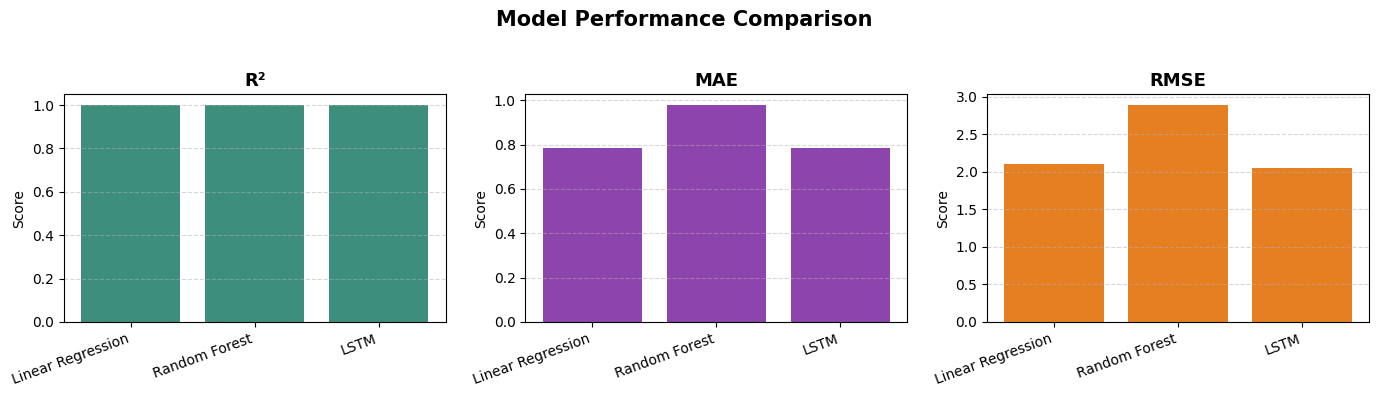

In [ ]:
# 1. Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# 2. Create a DataFrame with the best results obtained from previous model runs
#    These values represent the top-performing configurations after tuning.
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'R²': [0.9993, 0.9987, 0.9994],
    'MAE': [0.7848, 0.9783, 0.7839],
    'RMSE': [2.1053, 2.8907, 2.0476]
})

# 3. Display the comparison table
display(comparison_df.style.hide(axis="index").set_caption("Performance Comparison Across Models"))

# 4. Plot bar charts for each evaluation metric (R², MAE, RMSE)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
metrics = ['R²', 'MAE', 'RMSE']
colors = ['#3E8E7E', '#8E44AD', '#E67E22']

for i, metric in enumerate(metrics):
    # Plot bars for each metric
    axes[i].bar(comparison_df['Model'], comparison_df[metric], color=colors[i])
    axes[i].set_title(metric, fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Properly set x-ticks and labels (prevents overlapping or warnings)
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels(comparison_df['Model'], rotation=20, ha='right', fontsize=10)

# 5. Add a global title and adjust layout for clarity
plt.suptitle('Model Performance Comparison', fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



### **Discussion and Analysis**

All models achieved **very high R² values**, confirming that the dataset is highly predictable
and the models successfully captured the underlying trend of stock movements.  
However, their differences become clearer when analyzing the **error metrics (MAE and RMSE)**.

- **Linear Regression:**  
  Served as a strong baseline model but showed limited ability to capture non-linear or sequential dependencies.  

- **Random Forest Regression:**  
  Improved over the baseline by handling non-linearity, but showed slightly higher errors,
  suggesting possible overfitting or lack of temporal understanding.  

- **LSTM (Long Short-Term Memory):**  
  Achieved the **best overall performance** with the lowest MAE (0.7839) and RMSE (2.04),
  and the highest R² (0.9994).  
  This confirms that deep learning architectures, particularly LSTM,
  are more suitable for **time-series forecasting tasks** like stock price prediction.

**Conclusion:**  
The LSTM model (Units=128, Batch size=64, Epochs=10, Optimizer='rmsprop')
outperformed the other models and will be used in the final stage of the project
to generate trend-based classification (Buy / Not Buy) decisions.

### **Save Best Models**

These cells save the best-performing versions of the Linear Regression, Random Forest, and LSTM models so they can be used later during the live testing step.

In [ ]:
from sklearn.linear_model import LinearRegression
import joblib

best_lin_row = df_lin_results.iloc[0]
best_fit_intercept = bool(best_lin_row["fit_intercept"])

X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])

best_lr = LinearRegression(fit_intercept=best_fit_intercept)
best_lr.fit(X_train_flat, y_train)

joblib.dump(best_lr, "/content/best_linear_model.pkl")
print("Saved best Linear Regression model.")


Saved best Linear Regression model.


In [ ]:
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

best_rf_row = df_rf_results.iloc[0]
best_n = int(best_rf_row["n_estimators"])
best_depth = None if pd.isna(best_rf_row["max_depth"]) else int(best_rf_row["max_depth"])

X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])

best_rf = RandomForestRegressor(
    n_estimators=best_n,
    max_depth=best_depth,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_flat, y_train)

joblib.dump(best_rf, "/content/best_rf_model.pkl")
print("Saved best RF model.")


Saved best RF model.


## **Section 5 — Final Prediction**
We now proceed with generating next-day closing price predictions using the selected LSTM (Long Short-Term Memory) model. This model, designed for sequential data, is well-suited for capturing temporal patterns in stock price movements. It will use the most recent 20-day window for each company to forecast the next closing price.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Load the best saved LSTM model
model = load_model("/content/best_lstm_model.keras")

# Evaluate performance on test set
y_hat_norm = model.predict(X_test, verbose=0).reshape(-1)
y_hat = y_hat_norm * te_sig + te_mu
y_true = y_test * te_sig + te_mu

R2   = r2_score(y_true, y_hat)
MAE  = mean_absolute_error(y_true, y_hat)
RMSE = float(np.sqrt(mean_squared_error(y_true, y_hat)))

print("\n=== Final LSTM Evaluation (Best Saved Model) ===")
print(f"R²   = {R2:.4f}")
print(f"MAE  = {MAE:.4f}")
print(f"RMSE = {RMSE:.4f}")

# Predict next-day closing prices for each company
pred_rows = []
for rec in next_day_preds:
    comp = rec["اسم الشركة"]
    if "last_window_norm" not in rec:
        pred_rows.append({"اسم الشركة": comp, "next_day_pred": np.nan})
        continue

    pred_norm = model.predict(rec["last_window_norm"], verbose=0).reshape(-1)[0]
    pred = pred_norm * rec["sigma"] + rec["mu"]
    pred_rows.append({"اسم الشركة": comp, "next_day_pred": float(pred)})

# Create DataFrame with predictions
pred_df = pd.DataFrame(pred_rows)
print("\n Sample next-day predictions (first 10):")
print(pred_df.head(10))

# Optional: save predictions
# pred_df.to_csv("/content/lstm_next_day_predictions.csv", index=False, encoding="utf-8-sig")




=== Final LSTM Evaluation (Best Saved Model) ===
R²   = 0.9994
MAE  = 0.7839
RMSE = 2.0476

 Sample next-day predictions (first 10):
                                اسم الشركة  next_day_pred
0                 إعمار المدينة الإقتصادية      19.039892
1                     البنك الأهلي السعودي      33.540012
2                      البنك السعودي الأول      33.730587
3                    البنك السعودي الفرنسي      15.904469
4                  البنك السعودي للإستثمار      14.530499
5                      البنك العربي الوطني      21.116131
6                 الشركة التعاونية للتأمين     147.261673
7  الشركة الخليجية العامة للتأمين التعاوني      10.499896
8            الشركة السعودية لأنابيب الصلب      64.327492
9           الشركة السعودية لإعادة التأمين      49.894890


### **Section 6-Build Classification Dataset (20-day window + Buy/Not Buy label)**

This code creates a classification dataset using the past 20 days as input and the next-day price as the target. A Buy/Not Buy label is generated based on whether day-21 price is higher than day-20.

In [ ]:
WINDOW_LEN = 20  # Number of days we use as input

seq_rows = []

# We make sure that df_d is sorted correctly
df_seq = df_d.sort_values(["اسم الشركة", "التاريخ"]).copy()

for comp, g in df_seq.groupby("اسم الشركة"):
    g = g.sort_values("التاريخ")
    prices = g["إقفال"].values.astype("float64")
    dates   = g["التاريخ"].values

    # We need at least 21 days for a 20-day window + target 1
    if len(prices) < WINDOW_LEN + 1:
        continue

    # Each row: Day 20 (feature) + Day 21 (target) + label buy/not buy
    # window = Prices from t-20 to t-1, target = Price at t
    for t in range(WINDOW_LEN, len(prices)):
        window_vals = prices[t-WINDOW_LEN:t]   # 20 days ago
        target_price = prices[t]               # Day 21 (Goal)
        target_date  = dates[t]                # Today's date 21

        # Ignore any window containing NaN
        if np.isnan(window_vals).any() or np.isnan(target_price):
            continue

        last_price_in_window = window_vals[-1]

        # label: 1 = Buy if day 21 is greater than day 20, otherwise 0
        label_buy = int(target_price > last_price_in_window)

        row = {
            "اسم الشركة": comp,
            "تاريخ_الهدف": target_date,
            "سعر_اليوم21": float(target_price),
            "سعر_اليوم20": float(last_price_in_window),
            "label_buy": label_buy
        }

        # We add the columns day_1 .. day_20 (from oldest to newest)
        for i in range(WINDOW_LEN):
            row[f"day_{i+1}"] = float(window_vals[i])

        seq_rows.append(row)

# We convert it to DataFrame
wide_seq_df = pd.DataFrame(seq_rows)

print("Wide dataset shape:", wide_seq_df.shape)
print(wide_seq_df.head())

# We save it in the drive
SEQ_PATH = "/content/drive/My Drive/Colab Notebooks/wide_20days_nextday_buylabel.csv"
wide_seq_df.to_csv(SEQ_PATH, index=False, encoding="utf-8-sig")

print("Saved wide dataset to:", SEQ_PATH)


Wide dataset shape: (215055, 25)
                 اسم الشركة تاريخ_الهدف  سعر_اليوم21  سعر_اليوم20  label_buy  \
0  إعمار المدينة الإقتصادية  2021-01-31        19.33        19.59          0   
1  إعمار المدينة الإقتصادية  2021-02-01        19.20        19.33          0   
2  إعمار المدينة الإقتصادية  2021-02-02        18.92        19.20          0   
3  إعمار المدينة الإقتصادية  2021-02-03        18.42        18.92          0   
4  إعمار المدينة الإقتصادية  2021-02-04        18.20        18.42          0   

   day_1  day_2  day_3  day_4  day_5  ...  day_11  day_12  day_13  day_14  \
0  19.72  20.00  19.80  19.70  19.76  ...   19.63   19.83   19.74   19.63   
1  20.00  19.80  19.70  19.76  19.89  ...   19.83   19.74   19.63   19.63   
2  19.80  19.70  19.76  19.89  19.91  ...   19.74   19.63   19.63   19.54   
3  19.70  19.76  19.89  19.91  19.91  ...   19.63   19.63   19.54   19.63   
4  19.76  19.89  19.91  19.91  19.72  ...   19.63   19.54   19.63   19.54   

   day_15  day_16  day_

###**Section 7-Prepare 5 Test Examples (prices + labels) for Live Testing**

This code selects 5 samples from the test set, converts normalized values back to original prices, computes the true Buy/Not Buy labels, and saves everything into an .npz file for use in live testing.

In [ ]:
import numpy as np

WINDOW_LEN = X_test.shape[1]
n_test = len(y_test)
indices = np.linspace(0, n_test - 1, 5, dtype=int)
print("chosen indices:", indices)

X5 = X_test[indices]      # (5, 20, 1) – normalized
y5 = y_test[indices]      # normalized target (Day 21)
mu5 = te_mu[indices]
sig5 = te_sig[indices]

# returning prices to their original levels
true_21 = y5 * sig5 + mu5                # Today's Real Price 21
last20_norm = X5[:, -1, 0]               # The last item in the window (normalized)
last20 = last20_norm * sig5 + mu5        # Today's Real Price 20

# derive the actual label if you like from the prices (or use label_buy from CSV)
true_label = (true_21 > last20).astype(int)

np.savez(
    "/content/test_examples_5.npz",
    X5=X5,           # for models
    y5=y5,
    mu5=mu5,
    sig5=sig5,
    last20=last20,
    true_21=true_21,
    true_label=true_label
)

print("Saved 5 examples with prices + labels.")


chosen indices: [    0 10760 21521 32282 43043]
Saved 5 examples with prices + labels.


### **Section 8-Live Testing: Load Models + Predict Next-Day Price + Predict Buy/Not Buy**

This code loads the saved models, runs predictions on the 5 test examples, converts predicted prices into Buy/Not Buy decisions, and prints both true and predicted labels for each model.

In [ ]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# 1) Download the 5 examples we saved
data = np.load("/content/test_examples_5.npz")

X5         = data["X5"]         # (5, 20, 1) normalized
y5         = data["y5"]
mu5        = data["mu5"]
sig5       = data["sig5"]
last20     = data["last20"]     # Today's Real Price 20
true_21    = data["true_21"]    # Today's Real Price 21
true_label = data["true_label"] # 0/1

X5_flat = X5.reshape(X5.shape[0], X5.shape[1])

# 2) Download the best templates
lr   = joblib.load("/content/best_linear_model.pkl")
rf   = joblib.load("/content/best_rf_model.pkl")
lstm = load_model("/content/best_lstm_model.keras")

# 3) Predicting prices for today, day 21 (normalized)
p_lr_norm   = lr.predict(X5_flat)
p_rf_norm   = rf.predict(X5_flat)
p_lstm_norm = lstm.predict(X5, verbose=0).reshape(-1)

# 4) We return it to the real price
p_lr   = p_lr_norm * sig5 + mu5
p_rf   = p_rf_norm * sig5 + mu5
p_lstm = p_lstm_norm * sig5 + mu5

# 5) We derive the expected label from the price:
# If the predicted price for day 21 > the price for day 20 → Buy (1) Otherwise, Not Buy (0)
pred_label_lr   = (p_lr   > last20).astype(int)
pred_label_rf   = (p_rf   > last20).astype(int)
pred_label_lstm = (p_lstm > last20).astype(int)

# 6) We print the results neatly
print("\nنتائج 5 أمثلة (سعر + Label):\n")
for i in range(len(true_21)):
    print(f"العينة {i+1}:")
    print(f"  سعر اليوم 20 الحقيقي : {last20[i]:.2f}")
    print(f"  سعر اليوم 21 الحقيقي : {true_21[i]:.2f}")
    print(f"  اللابل الحقيقي       : {'Buy' if true_label[i]==1 else 'Not Buy'}")
    print()
    print(f"  Linear Regression → سعر متنبأ: {p_lr[i]:.2f} | Label: {'Buy' if pred_label_lr[i]==1 else 'Not Buy'}")
    print(f"  Random Forest     → سعر متنبأ: {p_rf[i]:.2f} | Label: {'Buy' if pred_label_rf[i]==1 else 'Not Buy'}")
    print(f"  LSTM              → سعر متنبأ: {p_lstm[i]:.2f} | Label: {'Buy' if pred_label_lstm[i]==1 else 'Not Buy'}")
    print("-" * 60)



نتائج 5 أمثلة (سعر + Label):

العينة 1:
  سعر اليوم 20 الحقيقي : 17.66
  سعر اليوم 21 الحقيقي : 18.94
  اللابل الحقيقي       : Buy

  Linear Regression → سعر متنبأ: 17.70 | Label: Buy
  Random Forest     → سعر متنبأ: 17.68 | Label: Buy
  LSTM              → سعر متنبأ: 17.73 | Label: Buy
------------------------------------------------------------
العينة 2:
  سعر اليوم 20 الحقيقي : 9.05
  سعر اليوم 21 الحقيقي : 9.00
  اللابل الحقيقي       : Not Buy

  Linear Regression → سعر متنبأ: 9.11 | Label: Buy
  Random Forest     → سعر متنبأ: 9.05 | Label: Not Buy
  LSTM              → سعر متنبأ: 9.11 | Label: Buy
------------------------------------------------------------
العينة 3:
  سعر اليوم 20 الحقيقي : 42.65
  سعر اليوم 21 الحقيقي : 42.90
  اللابل الحقيقي       : Buy

  Linear Regression → سعر متنبأ: 42.82 | Label: Buy
  Random Forest     → سعر متنبأ: 42.63 | Label: Not Buy
  LSTM              → سعر متنبأ: 42.69 | Label: Buy
------------------------------------------------------------
العين

## **Section 8-The Result**
###  **Classification Evaluation on Full Test Set (Confusion Matrices)**



Linear Regression – Accuracy on test set: 0.4924
Confusion Matrix (rows = true, cols = predicted):
[[10573 13829]
 [ 8020 10622]]


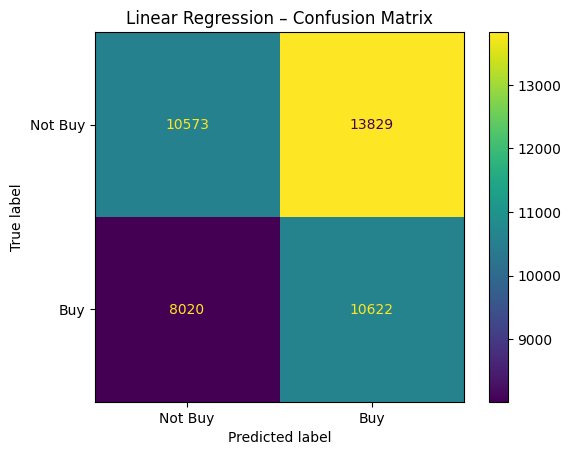


Random Forest – Accuracy on test set: 0.4847
Confusion Matrix (rows = true, cols = predicted):
[[10214 14188]
 [ 7991 10651]]


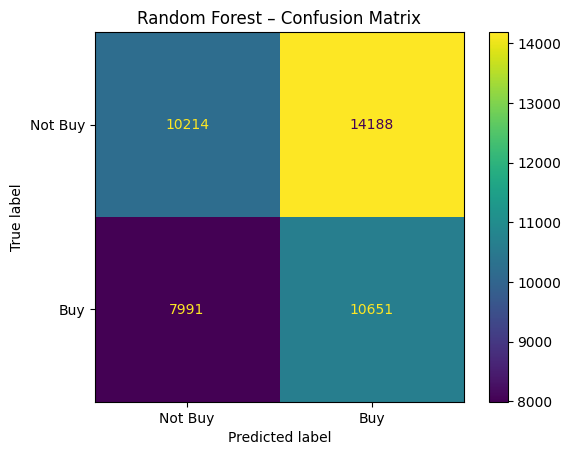


LSTM – Accuracy on test set: 0.4550
Confusion Matrix (rows = true, cols = predicted):
[[ 4441 19961]
 [ 3497 15145]]


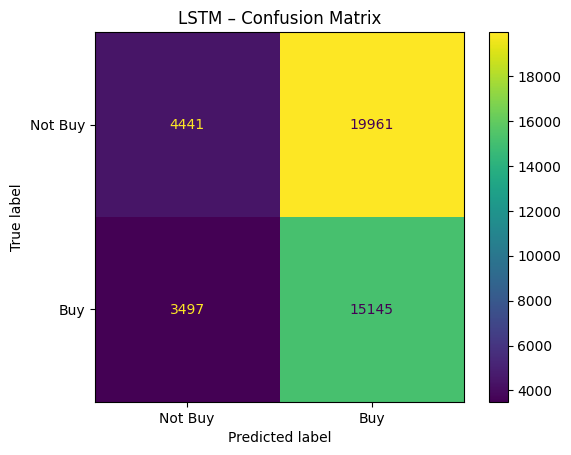

In [ ]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
import numpy as np

# 1) Preparing test data
# X_test: (N, 20, 1) | y_test: normalized next-day price
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1])  # for Sklearn models

mu  = te_mu   # The same Mio you used when you were using Dinonormalise
sig = te_sig  # Same Sigma

# Today's Real Prices 21
true_21 = y_test * sig + mu

# Today's actual price (last day in the window)
last20_norm = X_test[:, -1, 0]        # normalized
last20      = last20_norm * sig + mu  # real scale

# Real Label: 1 = Buy if today is 21 > today is 20, otherwise 0
true_label = (true_21 > last20).astype(int)

# 2) Download the best file models
lr_best   = joblib.load("/content/best_linear_model.pkl")
rf_best   = joblib.load("/content/best_rf_model.pkl")
lstm_best = load_model("/content/best_lstm_model.keras")

# 3) Price forecasting (normalized)
lr_pred_norm   = lr_best.predict(X_test_flat)
rf_pred_norm   = rf_best.predict(X_test_flat)
lstm_pred_norm = lstm_best.predict(X_test, verbose=0).reshape(-1)

# 4) Converting them to real prices
lr_pred   = lr_pred_norm * sig + mu
rf_pred   = rf_pred_norm * sig + mu
lstm_pred = lstm_pred_norm * sig + mu

# 5) Deriving the predicted price from the price:
# If predicted_day21 > day20 → Buy (1) Otherwise Not Buy (0)
lr_label   = (lr_pred   > last20).astype(int)
rf_label   = (rf_pred   > last20).astype(int)
lstm_label = (lstm_pred > last20).astype(int)

# 6) Calculation of Confusion Matrix + Accuracy for each model
models_labels = [
    ("Linear Regression", lr_label),
    ("Random Forest",     rf_label),
    ("LSTM",              lstm_label),
]

for name, pred in models_labels:
    cm = confusion_matrix(true_label, pred)
    acc = accuracy_score(true_label, pred)

    print(f"\n{name} – Accuracy on test set: {acc:.4f}")
    print("Confusion Matrix (rows = true, cols = predicted):")
    print(cm)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Buy", "Buy"]
    )
    disp.plot(values_format="d")
    plt.title(f"{name} – Confusion Matrix")
    plt.grid(False)
    plt.show()


### **ROC Curves for Buy vs Not Buy (All Models)**

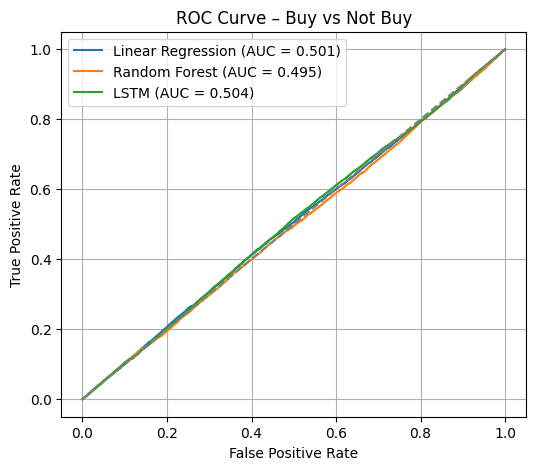

In [ ]:
### === ROC Curves for Buy vs Not Buy (All Models) ===

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# We use the predicted - last20 price difference as a continuous score:
# Large positive value → Higher confidence (it's a Buy)
# Negative value → Closer to Not Buying
score_lr   = lr_pred   - last20
score_rf   = rf_pred   - last20
score_lstm = lstm_pred - last20

plt.figure(figsize=(6, 5))

def plot_roc(true_y, scores, label):
    fpr, tpr, _ = roc_curve(true_y, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

plot_roc(true_label, score_lr,   "Linear Regression")
plot_roc(true_label, score_rf,   "Random Forest")
plot_roc(true_label, score_lstm, "LSTM")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Buy vs Not Buy")
plt.legend()
plt.grid(True)
plt.show()


### **LSTM Learning Curve**

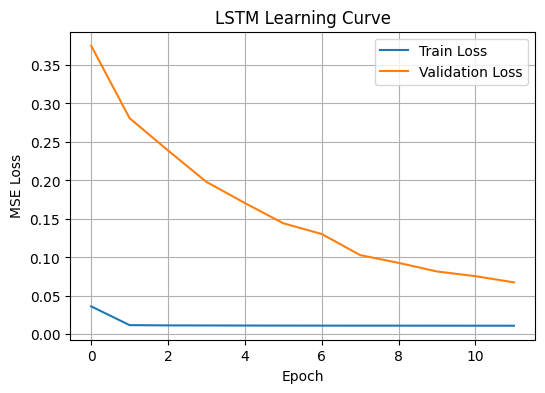

In [ ]:
# LSTM Learning Curve (Train vs Validation Loss)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Learning Curve")
plt.legend()
plt.grid(True)
plt.show()
